In [1]:
import collections
import dataclasses

from matplotlib import pyplot
from numpy import random
from scipy import stats

## 6.2, Programming fake-data simulation

> Write an R function to: (i) simulate $n$ data points from the model,
> $y = a + bx + \text{error}$, with data points $x$ uniformly sampled from the
> range (0, 100) and with errors drawn independently from the normal
> distribution with mean 0 and standard deviation $\sigma$; (ii) fit a linear
> regression to the simulated data; and (iii) make a scatterplot of the data
> and fitted regression line. Your function should take as arguments, $a$, $b$,
> $n$, $\sigma$, and it should return the data, print out the fitted regression,
> and make the plot. Check your function by trying it out on some values of $a$,
> $b$, $n$, $\sigma$.

Just for the record, if someone handed me this spec in a genuine professional
context, I would refuse to implement it.  Too many things going on here at
once, and many of the operations and returned values are relatively simple views
of each other.

In [2]:
@dataclasses.dataclass
class SimpleRegression:
    """A dataset that demonstrates a simple univariate linear regression."""
    xs: tuple[float, ...]
    ys: tuple[float, ...]
    model: collections.namedtuple
    plot: pyplot.Figure | None

    def __post_init__(self):
        if len(self.xs) != len(self.ys):
            raise ValueError(f"Something's wrong, len(xs) is {len(xs)} but len(ys) is {len(ys)}")

In [3]:
def simulate_simple_regression(a: float, b: float, n: int, sigma: float, include_fig: bool=True) -> SimpleRegression:
    if n < 2:
        raise ValueError(f'n must be greater than 1; got {n}')
    if sigma <= 0:
        raise ValueError(f'sigma must be positive; got {sigma}')
    rng = random.default_rng()
    xs = rng.uniform(low=0, high=100, size=n)
    ys = b * xs + rng.normal(loc=a, scale=sigma, size=n)
    model = stats.linregress(xs, ys)

    if include_fig:
        fig = pyplot.figure(figsize=(5, 4))
        ax = fig.gca()
        ax.plot(xs, ys, 'b.')
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        slope_lo = model.slope - 2 * model.stderr
        slope_hi = model.slope + 2 * model.stderr
        int_lo = model.intercept - 2 * model.intercept_stderr
        int_hi = model.intercept + 2 * model.intercept_stderr
        ax.set_title(
            f'Slope: [{slope_lo:0.2f}, {slope_hi:0.2f}], ' +
            f'Intercept: [{int_lo:0.1f}, {int_hi:0.1f}], ' +
            f'N: {n}',
            fontsize=11
        )
        ax.plot((0, 100), tuple(model.intercept + xi * model.slope for xi in (0, 100)), 'r-')
        m_lo = []
        m_hi = []
        for xi in range(0, 101):
            m_candidates = [
                slope_lo * xi + int_lo,
                slope_lo * xi + int_hi,
                slope_hi * xi + int_lo,
                slope_hi * xi + int_hi,
            ]
            m_lo.append(min(m_candidates))
            m_hi.append(max(m_candidates))
        ax.plot(tuple(range(0, 101)), m_lo, 'r--')
        ax.plot(tuple(range(0, 101)), m_hi, 'r--')
        ax.fill_between(tuple(range(0, 101)), m_lo, m_hi, color='red', alpha=0.1)
        ax.grid()
    else:
        fig = None

    return SimpleRegression(
        xs=tuple(xi for xi in xs.ravel()),
        ys=tuple(yi for yi in ys.ravel()),
        model=model,
        plot=fig,
    )

/tmp/ipykernel_3323/881327297.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  regsim.plot.show()
/tmp/ipykernel_3323/881327297.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  regsim.plot.show()


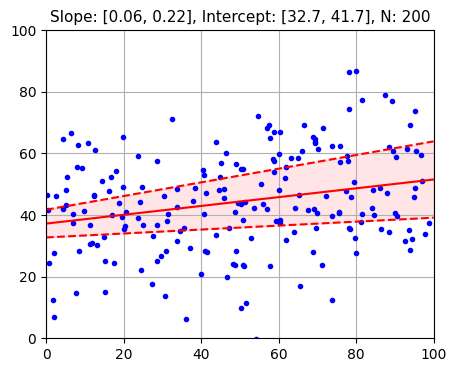

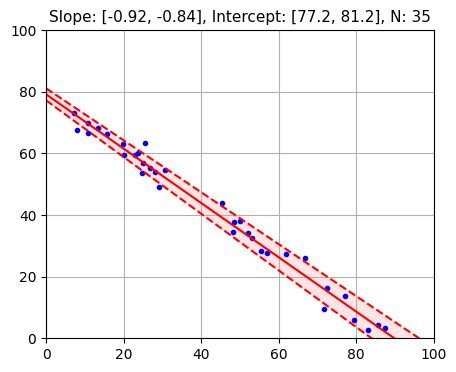

In [4]:
regsim = simulate_simple_regression(a=30, b=0.25, n=200, sigma=15)
regsim.plot.show()

regsim = simulate_simple_regression(a=80, b=-0.9, n=35, sigma=4)
regsim.plot.show()

## 6.3, Variation, uncertainty, and sample size

> Repeat the example in Section 6.2, varying the number of data points, $n$.
> What happens to the parameter estimates and uncertainties when you increase
> the number of observations?

/tmp/ipykernel_3323/3856877484.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  simulate_simple_regression(a=30, b=0.25, n=n, sigma=15).plot.show()


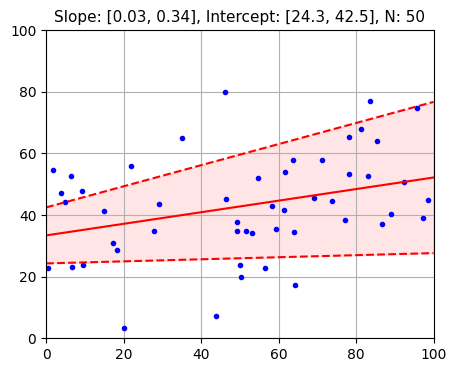

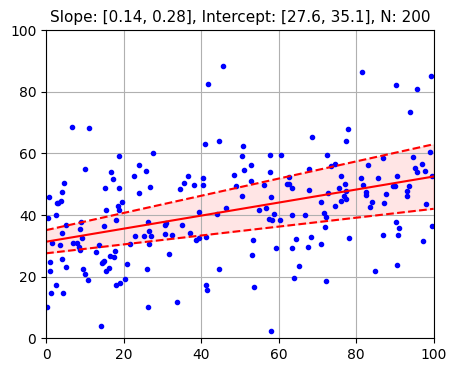

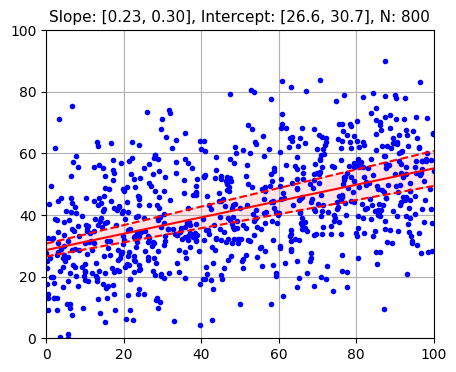

In [5]:
for n in (50, 200, 800):
    simulate_simple_regression(a=30, b=0.25, n=n, sigma=15).plot.show()    

## 6.4, Simulation study

> Perform the previous exercise more systematically, trying out a sequence of
> values of $n$, for each simulating fake data and fitting the regression to
> obtain estimate and uncertainty (median and mad sd) for each parameter. Then
> plot each of these as a function of $n$ and report on what you find.

Text(0.5, 0, 'Sample size')

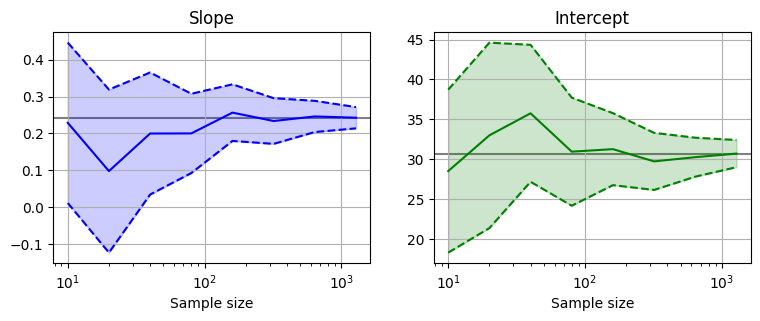

In [6]:
slope_lo = []
slope = []
slope_hi = []
int_lo = []
intercept = []
int_hi = []
ns = tuple([10, 20, 40, 80, 160, 320, 640, 1280])
for n in ns:
    regsim = simulate_simple_regression(a=30, b=0.25, n=n, sigma=15, include_fig=False)
    slope_lo.append(regsim.model.slope - 2 * regsim.model.stderr)
    slope.append(regsim.model.slope)
    slope_hi.append(regsim.model.slope + 2 * regsim.model.stderr)
    int_lo.append(regsim.model.intercept - 2 * regsim.model.intercept_stderr)
    intercept.append(regsim.model.intercept)
    int_hi.append(regsim.model.intercept + 2 * regsim.model.intercept_stderr)
fig, axs = pyplot.subplots(ncols=2, figsize=(9, 3))

axs[0].semilogx(ns, slope, 'b-')
axs[0].semilogx(ns, slope_lo, 'b--')
axs[0].semilogx(ns, slope_hi, 'b--')
axs[0].fill_between(ns, slope_lo, slope_hi, color='b', alpha=0.2)
axs[0].grid()
axs[0].axhline(color='grey', y=slope[-1], zorder=0)
axs[0].set_title('Slope')
axs[0].set_xlabel('Sample size')

axs[1].semilogx(ns, intercept, 'g-')
axs[1].semilogx(ns, int_lo, 'g--')
axs[1].semilogx(ns, int_hi, 'g--')
axs[1].fill_between(ns, int_lo, int_hi, color='g', alpha=0.2)
axs[1].grid()
axs[1].axhline(color='grey', y=intercept[-1], zorder=0)
axs[1].set_title('Intercept')
axs[1].set_xlabel('Sample size')


## 6.5, Regression prediction and averages

> The heights and earnings data in Section 6.3 are in the folder `Earnings`.
> Download the data and compute the average height for men and women in the
> sample.
>
> (a) Use these averages and fitted regression model displayed on page 84 to
>     get a model-based estimate of the average earnings of men and of women in
>     the population.
>
> (b) Assuming 52% of adults are women, estimate the average earnings of adults
>     in the population.
>
> (c) Directly from the sample data compute the average earnings of men, women,
>     and everyone.  Compare these to the values calculated in parts (a) and
>     (b).

## 6.6 Selection on x or y,

> (a) Repeat the analysis in Section 6.4 using the same data, but just analyzing
>     the observations for mothers’ heights less than the mean. Confirm that the
>     estimated regression parameters are roughly the same as were obtained by
>     fitting the model to all the data.
>
> (b) Repeat the analysis in Section 6.4 using the same data, but just analyzing
>     the observations for daughters’ heights less than the mean. Compare the
>     estimated regression parameters and discuss how they differ from what was
>     obtained by fitting the model to all the data.
>
> (c) Explain why selecting on daughters’ heights had so much more of an effect
>     on the fit than selecting on mothers’ heights.

## 6.7, Regression to the mean

> Gather before-after data with a structure similar to the mothers’ and
> daughters’ heights in Sections 6.4 and 6.5. These data could be performance of
> athletes or sports teams from one year to the next, or economic outcomes in
> states or countries in two successive years, or any other pair of measurements
> taken on a set of items. Standardize each of the two variables so it has a
> mean of 0 and standard deviation of 1.
>
> (a) Following the steps of Section 6.4, read in the data, fit a linear
>     regression, and plot the data and fitted regression line.
>
> (b) Repeat the above steps with fake data that look similar to the data you
>     have gathered.

## 6.8, Regression to the mean with fake data

> Perform a fake-data simulation as in Section 6.5, but using the flight school
> example on page 89. Simulate data from 500 pilots, each of whom performs two
> maneuvers, with each maneuver scored continuously on a 0–10 scale, that each
> pilot has a true ability that is unchanged during the two tasks, and that the
> score for each test is equal to this true ability plus independent errors.
> Further suppose that when pilots score higher than 7 on the scale during the
> first maneuver, that they get praised, and that scores lower than 3 on the
> first maneuver result in negative reinforcement. Also suppose, though, that
> this feedback has no effect on performance on the second task.
>
> (a) Make a scatterplot with one dot for each pilot, showing score on the
>     second maneuver vs. score on the first maneuver. Color the dots blue for
>     the pilots who got praised, red for those who got negative reinforcement,
>     and black for the other cases.
>
> (b) Compute the average change in scores for each group of pilots. If you did
>     your simulation correctly, the pilots who were praised did worse, on
>     average, and the pilots who got negative reinforcement improved, on
>     average, for the second maneuver. Explain how this happened, given that
>     your data were simulated under a model in which the positive and negative
>     messages had no effects.